# notes for Daan, remove when handing in

##### Dit zijn een aantal voorbeelden van hoe de verschillende classes gebruikt kunnen worden. De eerste titel over de steady_BEM class kan je in principe skippen, die doet verder niks anders dan gewoon een voorbeeld geven van hoe je de steady_BEM class gebruikt. Dus mocht het zo zijn dat je een quasi-steady solution nodig hebt, dan kan je die vinden met die class.

##### Verder voor de unsteady case, moet je zelf maar even kijken wat een geschikte 'dt' is en wat een geschikte maximale tijd is. Ik raad wel aan zelf even een apart bestandje te maken waarin je alle cases doet en zelf je plotjes maakt, die kan je natuurlijk gewoon deels kopiëren van dit bestandje, maar het is wel ietsje netter. Daarnaast moet je er denk ook even voor zorgen dat je de waardes die je plot normaliseerd zoals hij dat heeft gedaan in de tutorial, want dat is hier nog niet gedaan.

##### De uiteindelijke parameters die je plot, is aan jou. De outputs met uitleg staan erbij. Als je een andere output wil die hier nog niet bij staat (zoals bijv. angle of attack) stuur je maar een berichtje! Realiseer je wel dat er dus een verschil bestaat tussen de steady en unsteady waarde van CT

##### Voor assignment A2 is het een beetje onduidelijk wat precies de 'omega' is. Om een wat specifieker te zijn, waren we er niet zeker van of de waarde in het tabelletje van de assignment vermenigvuldigd moet worden met Uinf/R of dat we de waarde direct in kunnen vullen. In dat eerste geval, is de tijdspanne best wel groot namelijk. 

##### Als laatste, het kan zijn dat, zeker als je een hele hoge maximale tijd hebt, het unsteady model niet convergeert. Waarschijnlijk komt dit dan door het feit dat er een forward -Euler scheme wordt gebruikt om te integreren, wat misschien betekent dat je tijdstap te groot is.

In [29]:
!git pull

Already up to date.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from steady_BEM import steady_BEM
from unsteady_BEM import unsteady_BEM

# Example of how to use the steady_BEM class

In [2]:
# define flow conditions
Uinf = 10 # unperturbed wind speed in m/s
TSR = 10 # tip speed ratio
Radius = 50
N_blade_sec = 30
NBlades = 3

TipLocation_R =  1
RootLocation_R =  0.2
pitch = 2

airfoil = 'DU_polar.txt'

B = steady_BEM(airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, Uinf, TSR, N_blade_sec)
CT,CP, results = B.get_solution(pitch, Uinf)
print('CT: {}'.format(CT))
print('CP: {}'.format(CP))
    

CT: 0.7640241048359778
CP: 0.45811804894324043


# Example of how to use the unsteady case

In [3]:
# define flow conditions
Uinf = 10 # unperturbed wind speed in m/s
TSR = 10 # tip speed ratio
Radius = 50 #radius of the rotor
N_blade_sec = 30  #number of blade sections of one rotor blade
NBlades = 3 #number of blades
TipLocation_R =  1 #normalized location of the tip of the rotor
RootLocation_R =  0.2 #normalized location of the root of the rotor
spacing = 'cosine'  #spacing method to use for the rotor blade, can be 'cosine' or 'uniform'
airfoil = 'DU_polar.txt' #name of the file with the airfoil polars

#initialize the unsteady BEM model, note that for high pitch angles the model might return a warning that is not able
#to converge
B_unsteady = unsteady_BEM(airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, Uinf, TSR, N_blade_sec,spacing=spacing)

# Step change in thrust coefficient

In [4]:
#note that the B_unsteady instance only needs to be initialized once, after which each case for A1 and A2 can be run using
#a code similar to the one below.

#create the time array
dt = 0.008
time=20
time_range = np.arange(0,time,dt)
size_array=len(time_range)-1

# create velocity vector
U_time = Uinf*np.ones(len(time_range))
#create the quasi-steady thrust coefficient as a function of the above time vector
#initialize a vector the size of the time array with only values of CT0
CT0 = 0.5  
CT1 = 0.9
step_time = 0.5 #time at which the step in rotor configuration is applied in seconds

CT_time = CT0*np.ones(len(time_range))
#set all the values for the quasi-steady thrust coefficient after step_time seconds to the value for CT1
CT_time[time_range>step_time] = CT1

#define the inflow model
inflow_model = 'pitt_peters'
a_pp,ap_pp,fnorm_pp,ftan_pp,gamma_pp,Ct_pp, CT_pp, CP_pp=B_unsteady.get_solution(time_range,CT_time,U_time,inflow_model = inflow_model)
#return the results for the unsteady model 
#the results will all have the following structure, the rows correspond to the blade sections starting from the root 
#and the columns correspond to time. 
#
#a_pp            ====>  axial induction factor of the Pitt-Peters model
#ap_pp           ====>  azimuthal induction factor of the Pitt-Peters model
#fnorm_pp        ====>  value of the normal force on the airfoil, to get absolute value, multiply with width of blade section
#ftan_pp         ====>  value of the tangential force on the airfoil, to get absolute value, multiply with width of blade section
#gamma_pp        ====>  value of the circulation of the blade section
#Ct_pp           ====>  value of the local thrust coefficient for the annuli
#CT_pp           ====>  value of the overall thrust coefficient of the entire rotor in time, obviously is 1D array as opposed to 2D
#CP_pp           ====>  value of the overall power coefficient of the entire rotor in time, obviously is 1D array as opposed to 2D

inflow_model = 'oye'
a_oye,ap_oye,fnorm_oye,ftan_oye,gamma_oye,Ct_oye,CT_oye, CP_oye=B_unsteady.get_solution(time_range,CT_time,U_time,inflow_model = inflow_model)
#the same outputs as above apply, but this time it is for the oye model
inflow_model = 'larsen_madsen'
a_lm,ap_lm,fnorm_lm,ftan_lm,gamma_lm,Ct_lm,CT_lm,CP_lm=B_unsteady.get_solution(time_range,CT_time,U_time,inflow_model = inflow_model)
#the same outputs as above apply, but this time it is for the larsen madsen model

#get the steady solution, note that the class 'B_unsteady' has an instance of the class 'B_steady' , which can be used to find
#the value of the steady solution
CT_sol1,CP_sol1,steady_sol1 = B_unsteady.B_steady.get_solution(B_unsteady.pitch_time[0], U_time[0])
CT_sol2,CP_sol2,steady_sol2 = B_unsteady.B_steady.get_solution(B_unsteady.pitch_time[-1], U_time[-1])

we are at 96.67%


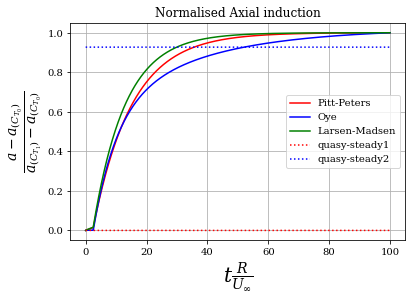

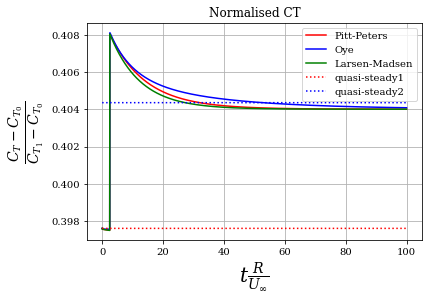

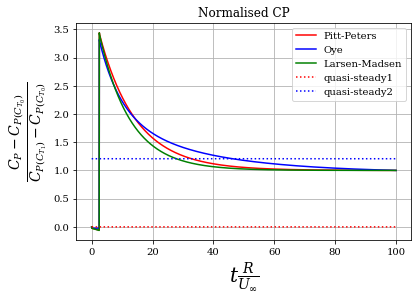

In [7]:
#plot results
plt.rcParams.update({'font.size': 10}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions


#plot of axial induction factor for annulus number 'annulus_num', note that Prandtl tip corrections are included
annulus_num = 18
# plt.figure(0)
# plt.plot(time_range,a_pp[annulus_num,:],'r',label='Pitt-Peters')
# plt.plot(time_range,a_oye[annulus_num,:],'b',label = 'Oye' )
# plt.plot(time_range,a_lm[annulus_num,:],'g',label='Larsen-Madsen')
# plt.plot(time_range,steady_sol1[annulus_num,0]*np.ones(len(time_range)),'r',linestyle='dotted', label = 'quasy-steady1')
# plt.plot(time_range,steady_sol2[annulus_num,0]*np.ones(len(time_range)),'b',linestyle='dotted', label = 'quasy-steady2')
# plt.legend()
# plt.grid(True)
# plt.title('Axial induction') #note, title can be better
# plt.xlabel('t [s]')
# plt.ylabel('a')

#plot the actual value of the thrust coefficient in time
# plt.figure(1)
# plt.plot(time_range,CT_pp,'r',label='Pitt-Peters')
# plt.plot(time_range,CT_oye,'b',label = 'Oye' )
# plt.plot(time_range,CT_lm,'g',label='Larsen-Madsen')
# plt.plot(time_range,CT_sol1*np.ones(len(time_range)),'r',linestyle='dotted', label = 'quasi-steady1')
# plt.plot(time_range,CT_sol2*np.ones(len(time_range)),'b',linestyle='dotted', label = 'quasi-steady2')
# plt.legend()
# plt.grid(True)
# plt.title('Actual CT') #note, title can be better
# plt.xlabel('t [s]')
# plt.ylabel('CT')

#same for the power coefficient
# plt.figure(2)
# plt.plot(time_range,CP_pp,'r',label='Pitt-Peters')
# plt.plot(time_range,CP_oye,'b',label = 'Oye' )
# plt.plot(time_range,CP_lm,'g',label='Larsen-Madsen')
# plt.plot(time_range,CP_sol1*np.ones(len(time_range)),'r',linestyle='dotted', label = 'quasi-steady1')
# plt.plot(time_range,CP_sol2*np.ones(len(time_range)),'b',linestyle='dotted', label = 'quasi-steady2')
# plt.legend()
# plt.grid(True)
# plt.title('Actual CP') #note, title can be better
# plt.xlabel('t [s]')
# plt.ylabel('CP')


#plot of non-dimensionalised axial induction factor for annulus number 'annulus_num', note that Prandtl tip corrections are included
fig_a=plt.figure(3)
plt.plot(time_range*Radius/Uinf,(a_pp[annulus_num,:]-a_pp[annulus_num,0])/(a_pp[annulus_num,size_array]-a_pp[annulus_num,0]),'r',label='Pitt-Peters')
plt.plot(time_range*Radius/Uinf,(a_oye[annulus_num,:]-a_oye[annulus_num,0])/(a_oye[annulus_num,size_array]-a_oye[annulus_num,0]),'b',label = 'Oye' )
plt.plot(time_range*Radius/Uinf,(a_lm[annulus_num,:]-a_lm[annulus_num,0])/(a_lm[annulus_num,size_array]-a_lm[annulus_num,0]),'g',label='Larsen-Madsen')
plt.plot(time_range*Radius/Uinf,(steady_sol1[annulus_num,0]*np.ones(len(time_range))-a_pp[annulus_num,0])/(a_pp[annulus_num,size_array]-a_pp[annulus_num,0]),'r',linestyle='dotted', label = 'quasy-steady1')
plt.plot(time_range*Radius/Uinf,(steady_sol2[annulus_num,0]*np.ones(len(time_range))-a_pp[annulus_num,0])/(a_pp[annulus_num,size_array]-a_pp[annulus_num,0]),'b',linestyle='dotted', label = 'quasy-steady2')
plt.legend()
plt.grid(True)
plt.title('Normalised Axial induction') #note, title can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{a-a_{\left(C_{T_0}\right)}}{a_{\left(C_{T_1}\right)}-a_{\left(C_{T_0}\right)}}$', fontsize=20)
fig_a.savefig('Case_A1/a_{}_{}.png'.format(CT1, CT0),bbox_inches = 'tight')


#plot the normalised value of the thrust coefficient in time
fig_Ct=plt.figure(4)
plt.plot(time_range*Radius/Uinf,(CT_pp-CT0)/(CT1-CT0),'r',label='Pitt-Peters')
plt.plot(time_range*Radius/Uinf,(CT_oye-CT0)/(CT1-CT0),'b',label = 'Oye' )
plt.plot(time_range*Radius/Uinf,(CT_lm-CT0)/(CT1-CT0),'g',label='Larsen-Madsen')
plt.plot(time_range*Radius/Uinf,(CT_sol1*np.ones(len(time_range))-CT0)/(CT1-CT0),'r',linestyle='dotted', label = 'quasi-steady1')
plt.plot(time_range*Radius/Uinf,(CT_sol2*np.ones(len(time_range))-CT0)/(CT1-CT0),'b',linestyle='dotted', label = 'quasi-steady2')
plt.legend()
plt.grid(True)
plt.title('Normalised CT') #note, title can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{C_T-C_{T_0}}{C_{T_1}-C_{T_0}}$', fontsize=20)
fig_Ct.savefig('Case_A1/CT_{}_{}.png'.format(CT1, CT0), bbox_inches = 'tight')

#same for the power coefficient
fig_CP=plt.figure(5)

plt.plot(time_range*Radius/Uinf,(CP_pp-CP_pp[0])/(CP_pp[size_array]-CP_pp[0]),'r',label='Pitt-Peters')
plt.plot(time_range*Radius/Uinf,(CP_oye-CP_oye[0])/(CP_oye[size_array]-CP_oye[0]),'b',label = 'Oye' )
plt.plot(time_range*Radius/Uinf,(CP_lm-CP_lm[0])/(CP_lm[size_array]-CP_lm[0]),'g',label='Larsen-Madsen')
plt.plot(time_range*Radius/Uinf,(CP_sol1*np.ones(len(time_range))-CP_lm[0])/(CP_lm[size_array]-CP_lm[0]),'r',linestyle='dotted', label = 'quasi-steady1')
plt.plot(time_range*Radius/Uinf,(CP_sol2*np.ones(len(time_range))-CP_lm[0])/(CP_lm[size_array]-CP_lm[0]),'b',linestyle='dotted', label = 'quasi-steady2')
plt.legend()
plt.grid(True)
plt.title('Normalised CP') #note, title can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{C_P-C_{P\left(C_{T_0}\right)}}{C_{P\left(C_{T_1}\right)}-C_{P\left(C_{T_0}\right)}}$', fontsize=20)
fig_CP.savefig('Case_A1/CP_{}_{}.png'.format(CT1, CT0),bbox_inches = 'tight')






# Sinusoidal rotor configuration change
###### note that all the parameters have a '_s' behind them. This is done to prevent the results from sinusoidal case from overwriting the step change case, so that you can plot the step change case even after you run the sinusoidal case 

In [8]:
#create the time array
max_time = 20 #upper bound on the time vector
dt = 0.01
time_range_s = np.arange(0,max_time,dt)
size_array_s = len(time_range_s)-1

# create velocity vector
U_time_s = Uinf*np.ones(len(time_range_s))

#create the quasi-steady thrust coefficient as a function of the above time vector
CT0_s = 0.2
Delta_CT = 0.7
omega_r_uinf = 0.3   #this value might need to be multiplied with Uinf/R, see assignment description

CT_time_s = CT0_s+Delta_CT*np.sin(omega_r_uinf*time_range_s)

#the same procedure as the step change applies
inflow_model = 'pitt_peters'
a_pp_s,ap_pp_s,fnorm_pp_s,ftan_pp_s,gamma_pp_s,Ct_pp_s, CT_pp_s, CP_pp_s=B_unsteady.get_solution(time_range_s,CT_time_s,U_time_s,inflow_model = inflow_model)
inflow_model = 'oye'
a_oye_s,ap_oye_s,fnorm_oye_s,ftan_oye_s,gamma_oye_s,Ct_oye_s, CT_oye_s, CP_oye_s=B_unsteady.get_solution(time_range_s,CT_time_s,U_time_s,inflow_model = inflow_model)
inflow_model = 'larsen_madsen'
a_lm_s,ap_lm_s,fnorm_lm_s,ftan_lm_s,gamma_lm_s,Ct_lm_s, CT_lm_s, CP_lm_s =B_unsteady.get_solution(time_range_s,CT_time_s,U_time_s,inflow_model = inflow_model)



we are at 96.67%


In [9]:
#now also simulate the response if a steady model is applied (i.e. the flow reacts immediately to a change in pitch)

#since the steady solution doesn't require integration in time, the resolution can be much lower to speed up the code
#therefore a new time array for the steady solution is defined with only 150 points
steady_time_array = np.linspace(0,time_range_s[-1],num=150)
#this does mean that a new steady CT and pitch in time need to be defined
steady_CT = CT0_s+Delta_CT*np.sin(omega_r_uinf*steady_time_array)
steady_pitch_array = B_unsteady.find_pitch(steady_CT)
steady_U_array = Uinf*np.ones(len(time_range))

#define some empty arrays for the results
a_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
ap_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
fnorm_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
ftan_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
gamma_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
Ct_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
CP_steady_s = np.zeros(len(steady_time_array))

#run through the steady time array to find the corresponding value for the pitch and solve the steady problem
for i in range(len(steady_time_array)):
    #the weight here is the weighting of the new value for induction in the iteration loop
    #the higher the value, the faster the model converges, but also, the more unstable the model is
    _, CP_steady_s[i], results_s = B_unsteady.B_steady.get_solution(steady_pitch_array[i], steady_U_array[i],weight=0.25)
    a_steady_s[:,i] = results_s[:,0]
    ap_steady_s[:,i] = results_s[:,1]
    fnorm_steady_s[:,i] = results_s[:,3]
    ftan_steady_s[:,i] = results_s[:,4]
    gamma_steady_s[:,i] = results_s[:,5]
    Ct_steady_s[:,i] = results_s[:,6]

Text(0, 0.5, 'a')

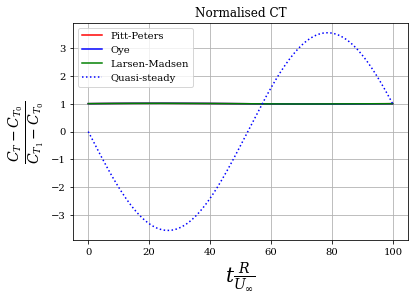

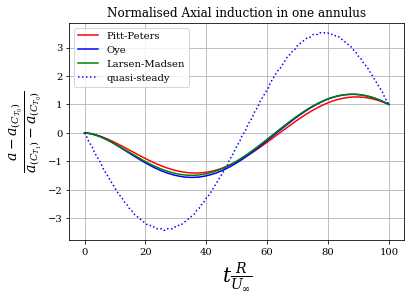

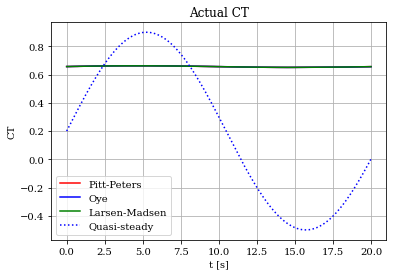

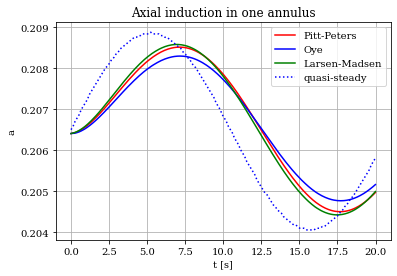

In [10]:
#plot the value for the overall thrust coefficient of the blade
plt.figure(5)
fig_CT_sin=plt.figure(5)
plt.plot(time_range_s*Radius/Uinf,(CT_pp_s-CT0_s)/(CT_pp_s[size_array_s]-CT0_s),'r',label='Pitt-Peters')
plt.plot(time_range_s*Radius/Uinf,(CT_oye_s-CT0_s)/(CT_lm_s[size_array_s]-CT0_s),'b',label = 'Oye' )
plt.plot(time_range_s*Radius/Uinf,(CT_lm_s-CT0_s)/(CT_lm_s[size_array_s]-CT0_s),'g',label='Larsen-Madsen')
plt.plot(time_range_s*Radius/Uinf,(CT_time_s-CT0_s)/(CT_time_s[size_array_s]-CT0_s), 'b', linestyle='dotted',label='Quasi-steady')
plt.legend()
plt.title('Normalised CT') #note, these can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{C_T-C_{T_0}}{C_{T_1}-C_{T_0}}$', fontsize=20)
plt.grid(True)
fig_CT_sin.savefig('Case_A2/CT_sin_{}_{}.png'.format(CT0_s, Delta_CT),bbox_inches = 'tight')


#plot the value for the axial induction at one annulus as a function of time
plt.figure(6)
annulus_num = 18
fig_a_sin=plt.figure(6)
plt.plot(time_range_s*Radius/Uinf,(a_pp_s[annulus_num,:]-a_pp_s[annulus_num,0])/(a_pp_s[annulus_num,size_array_s]-a_pp_s[annulus_num,0]),'r',label='Pitt-Peters')
plt.plot(time_range_s*Radius/Uinf,(a_oye_s[annulus_num,:]-a_oye_s[annulus_num,0])/(a_oye_s[annulus_num,size_array_s]-a_oye_s[annulus_num,0]),'b',label = 'Oye' )
plt.plot(time_range_s*Radius/Uinf,(a_lm_s[annulus_num,:]-a_lm_s[annulus_num,0])/(a_lm_s[annulus_num,size_array_s]-a_lm_s[annulus_num,0]),'g',label='Larsen-Madsen')
plt.plot(steady_time_array*Radius/Uinf,(a_steady_s[annulus_num,:]-a_steady_s[annulus_num,0])/(a_steady_s[annulus_num,149]-a_steady_s[annulus_num,0]),'b',linestyle='dotted', label = 'quasi-steady')
plt.legend()
plt.grid(True)
plt.title('Normalised Axial induction in one annulus') #note, title can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{a-a_{\left(C_{T_0}\right)}}{a_{\left(C_{T_1}\right)}-a_{\left(C_{T_0}\right)}}$', fontsize=20)
fig_a_sin.savefig('Case_A2/a_sin_{}_{}.png'.format(CT0_s, Delta_CT),bbox_inches = 'tight')

plt.figure()
plt.plot(time_range_s,CT_pp_s,'r',label='Pitt-Peters')
plt.plot(time_range_s,CT_oye_s,'b',label = 'Oye' )
plt.plot(time_range_s,CT_lm_s,'g',label='Larsen-Madsen')
plt.plot(time_range_s, CT_time_s, 'b', linestyle='dotted',label='Quasi-steady')
plt.legend()
plt.title('Actual CT') #note, these can be better
plt.xlabel('t [s]')
plt.ylabel('CT')
plt.grid(True)

#plot the value for the axial induction at one annulus as a function of time
plt.figure()
annulus_num = 15
plt.plot(time_range_s,a_pp_s[annulus_num,:],'r',label='Pitt-Peters')
plt.plot(time_range_s,a_oye_s[annulus_num,:],'b',label = 'Oye' )
plt.plot(time_range_s,a_lm_s[annulus_num,:],'g',label='Larsen-Madsen')
plt.plot(steady_time_array,a_steady_s[annulus_num,:],'b',linestyle='dotted', label = 'quasi-steady')
plt.legend()
plt.grid(True)
plt.title('Axial induction in one annulus') #note, title can be better
plt.xlabel('t [s]')
plt.ylabel('a')




# Step change in wind speed

In [11]:
#note that the B_unsteady instance only needs to be initialized once, after which each case for A1 and A2 can be run using
#a code similar to the one below.

#create the time array
dt = 0.008
time=20
time_range = np.arange(0,time,dt)
size_array=len(time_range)-1
step_time = 0.5 #time at which the step in rotor configuration is applied in seconds
U_step = 1.5 # step change in wind speed

# create quasi-steady inflow velocity as a function of the above time vector
U_time = Uinf*np.ones(len(time_range))
U_time = Uinf*np.ones(len(time_range))
U_time[time_range>step_time] = U_step*Uinf

# use a constant CT for the set pitch angle of -2 degrees
CT0 = B_unsteady.pitch_ct[(B_unsteady.pitch_ct[:,1] > 1.9) & (B_unsteady.pitch_ct[:,1]<2.1)][0][0]
CT_time = CT0*np.ones(len(time_range))

#define the inflow model
inflow_model = 'pitt_peters'
a_pp,ap_pp,fnorm_pp,ftan_pp,gamma_pp,Ct_pp, CT_pp, CP_pp=B_unsteady.get_solution(time_range,CT_time,U_time,inflow_model = inflow_model)
#return the results for the unsteady model 
#the results will all have the following structure, the rows correspond to the blade sections starting from the root 
#and the columns correspond to time. 
#
#a_pp            ====>  axial induction factor of the Pitt-Peters model
#ap_pp           ====>  azimuthal induction factor of the Pitt-Peters model
#fnorm_pp        ====>  value of the normal force on the airfoil, to get absolute value, multiply with width of blade section
#ftan_pp         ====>  value of the tangential force on the airfoil, to get absolute value, multiply with width of blade section
#gamma_pp        ====>  value of the circulation of the blade section
#Ct_pp           ====>  value of the local thrust coefficient for the annuli
#CT_pp           ====>  value of the overall thrust coefficient of the entire rotor in time, obviously is 1D array as opposed to 2D
#CP_pp           ====>  value of the overall power coefficient of the entire rotor in time, obviously is 1D array as opposed to 2D

inflow_model = 'oye'
a_oye,ap_oye,fnorm_oye,ftan_oye,gamma_oye,Ct_oye,CT_oye, CP_oye=B_unsteady.get_solution(time_range,CT_time,U_time,inflow_model = inflow_model)
#the same outputs as above apply, but this time it is for the oye model
inflow_model = 'larsen_madsen'
a_lm,ap_lm,fnorm_lm,ftan_lm,gamma_lm,Ct_lm,CT_lm,CP_lm=B_unsteady.get_solution(time_range,CT_time,U_time,inflow_model = inflow_model)
#the same outputs as above apply, but this time it is for the larsen madsen model

#get the steady solution, note that the class 'B_unsteady' has an instance of the class 'B_steady' , which can be used to find
#the value of the steady solution
CT_sol1,CP_sol1,steady_sol1 = B_unsteady.B_steady.get_solution(B_unsteady.pitch_time[0], U_time[0])
CT_sol2,CP_sol2,steady_sol2 = B_unsteady.B_steady.get_solution(B_unsteady.pitch_time[-1], U_time[-1])

we are at 96.67%


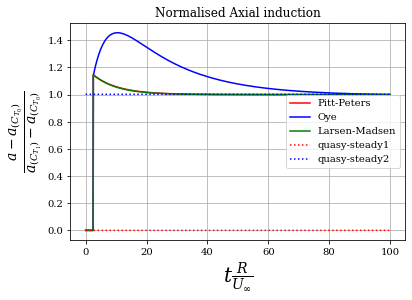

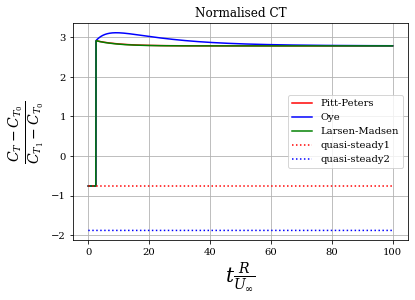

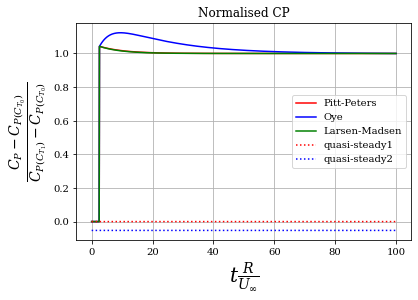

In [12]:
#plot results
plt.rcParams.update({'font.size': 10}) # define fontsize for the figures
plt.rcParams["font.family"] = "serif" # a nice font for the figures
plt.rcParams["mathtext.fontset"] = "dejavuserif"  # a nice font for the latex expressions


#plot of axial induction factor for annulus number 'annulus_num', note that Prandtl tip corrections are included
annulus_num = 18
# plt.figure(0)
# plt.plot(time_range,a_pp[annulus_num,:],'r',label='Pitt-Peters')
# plt.plot(time_range,a_oye[annulus_num,:],'b',label = 'Oye' )
# plt.plot(time_range,a_lm[annulus_num,:],'g',label='Larsen-Madsen')
# plt.plot(time_range,steady_sol1[annulus_num,0]*np.ones(len(time_range)),'r',linestyle='dotted', label = 'quasy-steady1')
# plt.plot(time_range,steady_sol2[annulus_num,0]*np.ones(len(time_range)),'b',linestyle='dotted', label = 'quasy-steady2')
# plt.legend()
# plt.grid(True)
# plt.title('Axial induction') #note, title can be better
# plt.xlabel('t [s]')
# plt.ylabel('a')

#plot the actual value of the thrust coefficient in time
# plt.figure(1)
# plt.plot(time_range,CT_pp,'r',label='Pitt-Peters')
# plt.plot(time_range,CT_oye,'b',label = 'Oye' )
# plt.plot(time_range,CT_lm,'g',label='Larsen-Madsen')
# plt.plot(time_range,CT_sol1*np.ones(len(time_range)),'r',linestyle='dotted', label = 'quasi-steady1')
# plt.plot(time_range,CT_sol2*np.ones(len(time_range)),'b',linestyle='dotted', label = 'quasi-steady2')
# plt.legend()
# plt.grid(True)
# plt.title('Actual CT') #note, title can be better
# plt.xlabel('t [s]')
# plt.ylabel('CT')

#same for the power coefficient
# plt.figure(2)
# plt.plot(time_range,CP_pp,'r',label='Pitt-Peters')
# plt.plot(time_range,CP_oye,'b',label = 'Oye' )
# plt.plot(time_range,CP_lm,'g',label='Larsen-Madsen')
# plt.plot(time_range,CP_sol1*np.ones(len(time_range)),'r',linestyle='dotted', label = 'quasi-steady1')
# plt.plot(time_range,CP_sol2*np.ones(len(time_range)),'b',linestyle='dotted', label = 'quasi-steady2')
# plt.legend()
# plt.grid(True)
# plt.title('Actual CP') #note, title can be better
# plt.xlabel('t [s]')
# plt.ylabel('CP')


#plot of non-dimensionalised axial induction factor for annulus number 'annulus_num', note that Prandtl tip corrections are included
fig_a=plt.figure(3)
plt.plot(time_range*Radius/Uinf,(a_pp[annulus_num,:]-a_pp[annulus_num,0])/(a_pp[annulus_num,size_array]-a_pp[annulus_num,0]),'r',label='Pitt-Peters')
plt.plot(time_range*Radius/Uinf,(a_oye[annulus_num,:]-a_oye[annulus_num,0])/(a_oye[annulus_num,size_array]-a_oye[annulus_num,0]),'b',label = 'Oye' )
plt.plot(time_range*Radius/Uinf,(a_lm[annulus_num,:]-a_lm[annulus_num,0])/(a_lm[annulus_num,size_array]-a_lm[annulus_num,0]),'g',label='Larsen-Madsen')
plt.plot(time_range*Radius/Uinf,(steady_sol1[annulus_num,0]*np.ones(len(time_range))-a_pp[annulus_num,0])/(a_pp[annulus_num,size_array]-a_pp[annulus_num,0]),'r',linestyle='dotted', label = 'quasy-steady1')
plt.plot(time_range*Radius/Uinf,(steady_sol2[annulus_num,0]*np.ones(len(time_range))-a_pp[annulus_num,0])/(a_pp[annulus_num,size_array]-a_pp[annulus_num,0]),'b',linestyle='dotted', label = 'quasy-steady2')
plt.legend()
plt.grid(True)
plt.title('Normalised Axial induction') #note, title can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{a-a_{\left(C_{T_0}\right)}}{a_{\left(C_{T_1}\right)}-a_{\left(C_{T_0}\right)}}$', fontsize=20)
fig_a.savefig('Case_B1/a_{}.png'.format(U_step),bbox_inches = 'tight')


#plot the normalised value of the thrust coefficient in time
fig_Ct=plt.figure(4)
plt.plot(time_range*Radius/Uinf,(CT_pp-CT0)/(CT1-CT0),'r',label='Pitt-Peters')
plt.plot(time_range*Radius/Uinf,(CT_oye-CT0)/(CT1-CT0),'b',label = 'Oye' )
plt.plot(time_range*Radius/Uinf,(CT_lm-CT0)/(CT1-CT0),'g',label='Larsen-Madsen')
plt.plot(time_range*Radius/Uinf,(CT_sol1*np.ones(len(time_range))-CT0)/(CT1-CT0),'r',linestyle='dotted', label = 'quasi-steady1')
plt.plot(time_range*Radius/Uinf,(CT_sol2*np.ones(len(time_range))-CT0)/(CT1-CT0),'b',linestyle='dotted', label = 'quasi-steady2')
plt.legend()
plt.grid(True)
plt.title('Normalised CT') #note, title can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{C_T-C_{T_0}}{C_{T_1}-C_{T_0}}$', fontsize=20)
fig_Ct.savefig('Case_B1/CT_{}.png'.format(U_step), bbox_inches = 'tight')

#same for the power coefficient
fig_CP=plt.figure(5)

plt.plot(time_range*Radius/Uinf,(CP_pp-CP_pp[0])/(CP_pp[size_array]-CP_pp[0]),'r',label='Pitt-Peters')
plt.plot(time_range*Radius/Uinf,(CP_oye-CP_oye[0])/(CP_oye[size_array]-CP_oye[0]),'b',label = 'Oye' )
plt.plot(time_range*Radius/Uinf,(CP_lm-CP_lm[0])/(CP_lm[size_array]-CP_lm[0]),'g',label='Larsen-Madsen')
plt.plot(time_range*Radius/Uinf,(CP_sol1*np.ones(len(time_range))-CP_lm[0])/(CP_lm[size_array]-CP_lm[0]),'r',linestyle='dotted', label = 'quasi-steady1')
plt.plot(time_range*Radius/Uinf,(CP_sol2*np.ones(len(time_range))-CP_lm[0])/(CP_lm[size_array]-CP_lm[0]),'b',linestyle='dotted', label = 'quasi-steady2')
plt.legend()
plt.grid(True)
plt.title('Normalised CP') #note, title can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{C_P-C_{P\left(C_{T_0}\right)}}{C_{P\left(C_{T_1}\right)}-C_{P\left(C_{T_0}\right)}}$', fontsize=20)
fig_CP.savefig('Case_B1/CP_{}.png'.format(U_step),bbox_inches = 'tight')






# Sinusoidal change in wind speed

In [22]:
#create the time array
max_time = 30 #upper bound on the time vector
dt = 0.01
time_range_s = np.arange(0,max_time,dt)
size_array_s = len(time_range_s)-1
U1_U0 = 1.0
deltaU = 0.5
omega_r_uinf = 0.3
azimuth = 0*np.pi/180

# create velocity vector
U_time_s = Uinf*U1_U0 + deltaU*np.sin(omega_r_uinf*time_range_s)*np.cos(azimuth)

# use a constant CT for the set pitch angle of -2 degrees
CT0 = B_unsteady.pitch_ct[(B_unsteady.pitch_ct[:,1] > 1.9) & (B_unsteady.pitch_ct[:,1]<2.1)][0][0]
CT_time_s = CT0*np.ones(len(time_range_s))

#the same procedure as the step change applies
inflow_model = 'pitt_peters'
a_pp_s,ap_pp_s,fnorm_pp_s,ftan_pp_s,gamma_pp_s,Ct_pp_s, CT_pp_s, CP_pp_s=B_unsteady.get_solution(time_range_s,CT_time_s,U_time_s,inflow_model = inflow_model)
inflow_model = 'oye'
a_oye_s,ap_oye_s,fnorm_oye_s,ftan_oye_s,gamma_oye_s,Ct_oye_s, CT_oye_s, CP_oye_s=B_unsteady.get_solution(time_range_s,CT_time_s,U_time_s,inflow_model = inflow_model)
inflow_model = 'larsen_madsen'
a_lm_s,ap_lm_s,fnorm_lm_s,ftan_lm_s,gamma_lm_s,Ct_lm_s, CT_lm_s, CP_lm_s =B_unsteady.get_solution(time_range_s,CT_time_s,U_time_s,inflow_model = inflow_model)



we are at 96.67%


In [23]:
#now also simulate the response if a steady model is applied (i.e. the flow reacts immediately to a change in pitch)

#since the steady solution doesn't require integration in time, the resolution can be much lower to speed up the code
#therefore a new time array for the steady solution is defined with only 150 points
steady_time_array = np.linspace(0,time_range_s[-1],num=150)
#this does mean that a new steady CT and pitch in time need to be defined
steady_CT = CT0*np.ones(len(steady_time_array))
steady_pitch_array = B_unsteady.find_pitch(steady_CT)
steady_U_array = Uinf*U1_U0 + deltaU*np.sin(omega_r_uinf*steady_time_array)*np.cos(azimuth)

#define some empty arrays for the results
a_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
ap_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
fnorm_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
ftan_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
gamma_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
Ct_steady_s = np.zeros([N_blade_sec,len(steady_time_array)])
CP_steady_s = np.zeros(len(steady_time_array))

#run through the steady time array to find the corresponding value for the pitch and solve the steady problem
for i in range(len(steady_time_array)):
    #the weight here is the weighting of the new value for induction in the iteration loop
    #the higher the value, the faster the model converges, but also, the more unstable the model is
    _, CP_steady_s[i], results_s = B_unsteady.B_steady.get_solution(steady_pitch_array[i], steady_U_array[i],weight=0.25)
    a_steady_s[:,i] = results_s[:,0]
    ap_steady_s[:,i] = results_s[:,1]
    fnorm_steady_s[:,i] = results_s[:,3]
    ftan_steady_s[:,i] = results_s[:,4]
    gamma_steady_s[:,i] = results_s[:,5]
    Ct_steady_s[:,i] = results_s[:,6]

Text(0, 0.5, 'a')

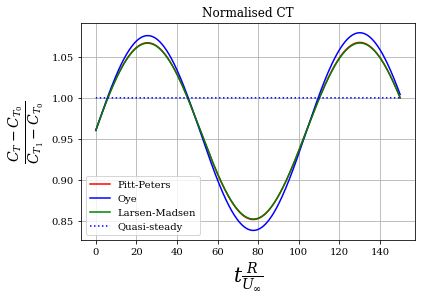

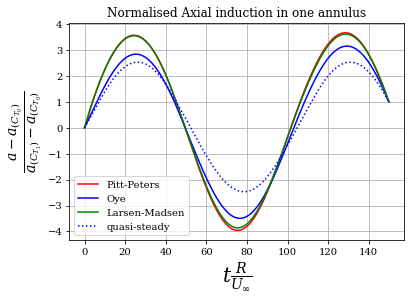

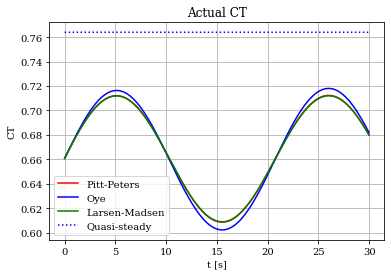

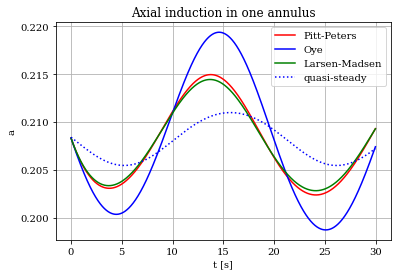

In [25]:
#plot the value for the overall thrust coefficient of the blade
plt.figure(5)
fig_CT_sin=plt.figure(5)
plt.plot(time_range_s*Radius/Uinf,(CT_pp_s-CT0_s)/(CT_pp_s[size_array_s]-CT0_s),'r',label='Pitt-Peters')
plt.plot(time_range_s*Radius/Uinf,(CT_oye_s-CT0_s)/(CT_lm_s[size_array_s]-CT0_s),'b',label = 'Oye' )
plt.plot(time_range_s*Radius/Uinf,(CT_lm_s-CT0_s)/(CT_lm_s[size_array_s]-CT0_s),'g',label='Larsen-Madsen')
plt.plot(time_range_s*Radius/Uinf,(CT_time_s-CT0_s)/(CT_time_s[size_array_s]-CT0_s), 'b', linestyle='dotted',label='Quasi-steady')
plt.legend()
plt.title('Normalised CT') #note, these can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{C_T-C_{T_0}}{C_{T_1}-C_{T_0}}$', fontsize=20)
plt.grid(True)
fig_CT_sin.savefig('Case_B2/CT_sin_{}_{}.png'.format(U1_U0, deltaU),bbox_inches = 'tight')


#plot the value for the axial induction at one annulus as a function of time
plt.figure(6)
annulus_num = 18
fig_a_sin=plt.figure(6)
plt.plot(time_range_s*Radius/Uinf,(a_pp_s[annulus_num,:]-a_pp_s[annulus_num,0])/(a_pp_s[annulus_num,size_array_s]-a_pp_s[annulus_num,0]),'r',label='Pitt-Peters')
plt.plot(time_range_s*Radius/Uinf,(a_oye_s[annulus_num,:]-a_oye_s[annulus_num,0])/(a_oye_s[annulus_num,size_array_s]-a_oye_s[annulus_num,0]),'b',label = 'Oye' )
plt.plot(time_range_s*Radius/Uinf,(a_lm_s[annulus_num,:]-a_lm_s[annulus_num,0])/(a_lm_s[annulus_num,size_array_s]-a_lm_s[annulus_num,0]),'g',label='Larsen-Madsen')
plt.plot(steady_time_array*Radius/Uinf,(a_steady_s[annulus_num,:]-a_steady_s[annulus_num,0])/(a_steady_s[annulus_num,149]-a_steady_s[annulus_num,0]),'b',linestyle='dotted', label = 'quasi-steady')
plt.legend()
plt.grid(True)
plt.title('Normalised Axial induction in one annulus') #note, title can be better
plt.xlabel(r'$t \frac{R}{U_\infty}$', fontsize=20)
plt.ylabel(r'$\frac{a-a_{\left(C_{T_0}\right)}}{a_{\left(C_{T_1}\right)}-a_{\left(C_{T_0}\right)}}$', fontsize=20)
fig_a_sin.savefig('Case_B2/a_sin_{}_{}.png'.format(U1_U0, deltaU),bbox_inches = 'tight')

plt.figure()
plt.plot(time_range_s,CT_pp_s,'r',label='Pitt-Peters')
plt.plot(time_range_s,CT_oye_s,'b',label = 'Oye' )
plt.plot(time_range_s,CT_lm_s,'g',label='Larsen-Madsen')
plt.plot(time_range_s, CT_time_s, 'b', linestyle='dotted',label='Quasi-steady')
plt.legend()
plt.title('Actual CT') #note, these can be better
plt.xlabel('t [s]')
plt.ylabel('CT')
plt.grid(True)

#plot the value for the axial induction at one annulus as a function of time
plt.figure()
annulus_num = 15
plt.plot(time_range_s,a_pp_s[annulus_num,:],'r',label='Pitt-Peters')
plt.plot(time_range_s,a_oye_s[annulus_num,:],'b',label = 'Oye' )
plt.plot(time_range_s,a_lm_s[annulus_num,:],'g',label='Larsen-Madsen')
plt.plot(steady_time_array,a_steady_s[annulus_num,:],'b',linestyle='dotted', label = 'quasi-steady')
plt.legend()
plt.grid(True)
plt.title('Axial induction in one annulus') #note, title can be better
plt.xlabel('t [s]')
plt.ylabel('a')


